In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import random
import numpy as np
from PIL import Image


from datasets import load_dataset
import random

dataset = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets", split="train")

ai_imgs = [ex for ex in dataset if ex["label"] == 0]
real_imgs = [ex for ex in dataset if ex["label"] == 1]

num_samples = min(len(ai_imgs), len(real_imgs)) // 2
ai_subset = random.sample(ai_imgs, num_samples)
real_subset = random.sample(real_imgs, num_samples)

subset = ai_subset + real_subset
random.shuffle(subset)

print(f"Usando {len(subset)} imágenes balanceadas")

# Splits estratificados
labels_all = [s["label"] for s in subset]

train_subset, test_subset = train_test_split(
    subset,
    test_size=0.15,
    stratify=labels_all,
    random_state=42
)

labels_train = [s["label"] for s in train_subset]

train_subset, val_subset = train_test_split(
    train_subset,
    test_size=0.2,
    stratify=labels_train,
    random_state=42
)

print("Train:", len(train_subset), "Val:", len(val_subset), "Test:", len(test_subset))


README.md:   0%|          | 0.00/590 [00:00<?, ?B/s]

data/train-00000-of-00006-336b26d54a26e1(…):   0%|          | 0.00/91.2M [00:00<?, ?B/s]

data/train-00001-of-00006-8ad2d550254dea(…):   0%|          | 0.00/25.9M [00:00<?, ?B/s]

data/train-00002-of-00006-ac8970f21c0418(…):   0%|          | 0.00/339M [00:00<?, ?B/s]

data/train-00003-of-00006-f635132ef309a7(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

data/train-00004-of-00006-1101eaf5152e1c(…):   0%|          | 0.00/40.5M [00:00<?, ?B/s]

data/train-00005-of-00006-4bd152a5ab76db(…):   0%|          | 0.00/565M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/152710 [00:00<?, ? examples/s]

Usando 71536 imágenes balanceadas
Train: 48644 Val: 12161 Test: 10731


In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def ae_data_generator(samples, batch_size=BATCH_SIZE, shuffle=True):
    """(x, x) para entrenar el autoencoder."""
    while True:
        if shuffle:
            random.shuffle(samples)
        for i in range(0, len(samples), batch_size):
            batch = samples[i:i+batch_size]
            images = []
            for ex in batch:
                img = ex["image"].convert("RGB").resize(IMG_SIZE)
                img_array = np.array(img, dtype="float32") / 255.0  # [0,1]
                images.append(img_array)
            x = np.array(images)
            yield x, x

def clf_data_generator(samples, batch_size=BATCH_SIZE, shuffle=True):
    """(x, y) para entrenar el clasificador."""
    while True:
        if shuffle:
            random.shuffle(samples)
        for i in range(0, len(samples), batch_size):
            batch = samples[i:i+batch_size]
            images, labels = [], []
            for ex in batch:
                img = ex["image"].convert("RGB").resize(IMG_SIZE)
                img_array = np.array(img, dtype="float32") / 255.0
                images.append(img_array)
                labels.append(ex["label"])  # 0=IA, 1=Real
            x = np.array(images)
            y = np.array(labels).astype("float32")
            yield x, y


In [3]:

train_ae_gen = ae_data_generator(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_ae_gen   = ae_data_generator(val_subset,   batch_size=BATCH_SIZE, shuffle=False)
steps_per_epoch_ae = max(1, len(train_subset) // BATCH_SIZE)
val_steps_ae       = max(1, len(val_subset)   // BATCH_SIZE)


train_clf_gen = clf_data_generator(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_clf_gen   = clf_data_generator(val_subset,   batch_size=BATCH_SIZE, shuffle=False)
steps_per_epoch_clf = max(1, len(train_subset) // BATCH_SIZE)
val_steps_clf       = max(1, len(val_subset)   // BATCH_SIZE)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


x = layers.Conv2D(32, (3,3), padding="same", use_bias=False)(input_img)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2,2), padding="same")(x)


x = layers.Conv2D(64, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2,2), padding="same")(x)


x = layers.Conv2D(128, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)


encoded = layers.MaxPooling2D((2,2), padding="same", name="encoded")(x)



x = layers.Conv2D(128, (3,3), padding="same", use_bias=False)(encoded)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(128, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2,2))(x)


x = layers.Conv2D(64, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(64, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2,2))(x)


x = layers.Conv2D(32, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, (3,3), padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2,2))(x)

decoded = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

autoencoder = models.Model(input_img, decoded, name="autoencoder_bn")
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


2025-11-25 04:50:00.281774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764046200.462162      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764046200.508657      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1764046213.706347      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764046213.706988      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "autoencoder_bn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 28, 28, 128)    │             

 Total params: 724,163 (2.76 MB)

 Trainable params: 722,371 (2.76 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [5]:
EPOCHS_AE = 5

history_ae = autoencoder.fit(
    train_ae_gen,
    steps_per_epoch=steps_per_epoch_ae,
    epochs=EPOCHS_AE,
    validation_data=val_ae_gen,
    validation_steps=val_steps_ae
)

Epoch 1/5


I0000 00:00:1764046221.036825     141 service.cc:148] XLA service 0x79040c042840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764046221.037735     141 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764046221.037746     141 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764046221.947413     141 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764046241.933995     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 188/1520 ━━━━━━━━━━━━━━━━━━━━ 4:25 199ms/step - loss: 0.0113

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1520/1520 ━━━━━━━━━━━━━━━━━━━━ 392s 240ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 2/5
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 380s 244ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 3/5
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 372s 245ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 4/5
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 373s 245ms/step - loss: 0.0011 - val_loss: 8.5438e-04
Epoch 5/5
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 372s 244ms/step - loss: 9.0834e-04 - val_loss: 0.0011


In [6]:

encoder_output = autoencoder.get_layer("encoded").output
encoder = models.Model(inputs=autoencoder.input, outputs=encoder_output, name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 28, 28, 128)    │             

 Total params: 288,352 (1.10 MB)

 Trainable params: 287,456 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
encoder.trainable = False  

clf_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = encoder(clf_input, training=False)           
x = layers.GlobalAveragePooling2D()(x)           
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
clf_output = layers.Dense(1, activation="sigmoid")(x)  

classifier = models.Model(clf_input, clf_output, name="ae_classifier")

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

classifier.summary()



Model: "ae_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 28, 28, 128)    │       288,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,633 (1.23 MB)

 Trainable params: 33,281 (130.00 KB)

 Non-trainable params: 288,352 (1.10 MB)

In [8]:
EPOCHS_CLF_HEAD = 10

history_clf_head = classifier.fit(
    train_clf_gen,
    steps_per_epoch=steps_per_epoch_clf,
    epochs=EPOCHS_CLF_HEAD,
    validation_data=val_clf_gen,
    validation_steps=val_steps_clf
)


Epoch 1/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - accuracy: 0.5962 - loss: 0.6624 - val_accuracy: 0.6539 - val_loss: 0.6045
Epoch 2/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 95s 62ms/step - accuracy: 0.6520 - loss: 0.6090 - val_accuracy: 0.6834 - val_loss: 0.5883
Epoch 3/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 94s 62ms/step - accuracy: 0.6692 - loss: 0.5848 - val_accuracy: 0.6840 - val_loss: 0.5520
Epoch 4/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 93s 61ms/step - accuracy: 0.6762 - loss: 0.5711 - val_accuracy: 0.7034 - val_loss: 0.5442
Epoch 5/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 93s 61ms/step - accuracy: 0.6895 - loss: 0.5549 - val_accuracy: 0.7131 - val_loss: 0.5264
Epoch 6/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 95s 62ms/step - accuracy: 0.7002 - loss: 0.5410 - val_accuracy: 0.7231 - val_loss: 0.5186
Epoch 7/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 93s 61ms/step - accuracy: 0.7050 - loss: 0.5370 - val_accuracy: 0.7250 - val_loss: 0.5195
Epoch 8/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 94s 62ms/step - accuracy: 0.7052 -

In [9]:
encoder.trainable = True  

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_CLF_FT = 10  

history_clf_ft = classifier.fit(
    train_clf_gen,
    steps_per_epoch=steps_per_epoch_clf,
    epochs=EPOCHS_CLF_FT,
    validation_data=val_clf_gen,
    validation_steps=val_steps_clf
)


Epoch 1/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 245s 157ms/step - accuracy: 0.7330 - loss: 0.5036 - val_accuracy: 0.7762 - val_loss: 0.4130
Epoch 2/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 235s 155ms/step - accuracy: 0.7701 - loss: 0.4384 - val_accuracy: 0.7909 - val_loss: 0.3906
Epoch 3/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 234s 154ms/step - accuracy: 0.7822 - loss: 0.4101 - val_accuracy: 0.7998 - val_loss: 0.3731
Epoch 4/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 234s 154ms/step - accuracy: 0.7874 - loss: 0.3967 - val_accuracy: 0.7909 - val_loss: 0.3836
Epoch 5/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 235s 154ms/step - accuracy: 0.7974 - loss: 0.3832 - val_accuracy: 0.8102 - val_loss: 0.3528
Epoch 6/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 234s 154ms/step - accuracy: 0.8067 - loss: 0.3681 - val_accuracy: 0.8117 - val_loss: 0.3521
Epoch 7/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 235s 155ms/step - accuracy: 0.8073 - loss: 0.3669 - val_accuracy: 0.7776 - val_loss: 0.4304
Epoch 8/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 235s 155ms/step - ac

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def predict_on_samples(model, samples, batch_size=32):
    all_preds = []
    all_labels = []
    for i in range(0, len(samples), batch_size):
        batch = samples[i:i+batch_size]
        images, labels = [], []
        for ex in batch:
            img = ex["image"].convert("RGB").resize(IMG_SIZE)
            img_array = np.array(img, dtype="float32") / 255.0
            images.append(img_array)
            labels.append(ex["label"])
        x = np.array(images)
        y = np.array(labels)
        probs = model.predict(x, verbose=0).ravel()
        all_preds.extend(probs.tolist())
        all_labels.extend(y.tolist())
    return np.array(all_preds), np.array(all_labels)

test_probs, test_labels = predict_on_samples(classifier, test_subset, batch_size=BATCH_SIZE)
test_pred = (test_probs >= 0.5).astype(int)

print("Accuracy test:", accuracy_score(test_labels, test_pred))
print("Matriz de confusión:\n", confusion_matrix(test_labels, test_pred))
print("Reporte de clasificación:\n", classification_report(test_labels, test_pred, target_names=["IA", "Real"]))


Accuracy test: 0.8180971018544404
Matriz de confusión:
 [[4288 1078]
 [ 874 4491]]
Reporte de clasificación:
               precision    recall  f1-score   support

          IA       0.83      0.80      0.81      5366
        Real       0.81      0.84      0.82      5365

    accuracy                           0.82     10731
   macro avg       0.82      0.82      0.82     10731
weighted avg       0.82      0.82      0.82     10731



Accuracy test: 0.8180971018544404
Reporte de clasificación:
               precision    recall  f1-score   support

          IA       0.83      0.80      0.81      5366
        Real       0.81      0.84      0.82      5365

    accuracy                           0.82     10731
   macro avg       0.82      0.82      0.82     10731
weighted avg       0.82      0.82      0.82     10731



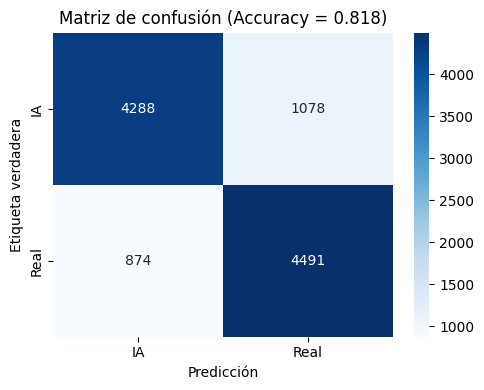

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



class_names = ["IA", "Real"] 

cm = confusion_matrix(test_labels, test_pred)
acc = accuracy_score(test_labels, test_pred)

print("Accuracy test:", acc)
print("Reporte de clasificación:\n", classification_report(test_labels, test_pred, target_names=class_names))

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title(f"Matriz de confusión (Accuracy = {acc:.3f})")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Historiales
loss_head = history_clf_head.history["loss"]
val_loss_head = history_clf_head.history["val_loss"]
acc_head = history_clf_head.history["accuracy"]
val_acc_head = history_clf_head.history["val_accuracy"]

loss_ft = history_clf_ft.history["loss"]
val_loss_ft = history_clf_ft.history["val_loss"]
acc_ft = history_clf_ft.history["accuracy"]
val_acc_ft = history_clf_ft.history["val_accuracy"]

# Ejes de épocas (continuos)
epochs_head = np.arange(1, len(loss_head) + 1)
epochs_ft = np.arange(len(loss_head) + 1,
                      len(loss_head) + len(loss_ft) + 1)

# --------- PLOT LOSS ---------
plt.figure(figsize=(7,4))
plt.plot(epochs_head, loss_head, label="Train loss (head)")
plt.plot(epochs_head, val_loss_head, label="Val loss (head)")
plt.plot(epochs_ft, loss_ft, label="Train loss (FT)")
plt.plot(epochs_ft, val_loss_ft, label="Val loss (FT)")
plt.axvline(x=len(loss_head), linestyle="--", label="Inicio fine-tuning")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución de la loss (cabeza + fine-tuning)")
plt.legend()
plt.tight_layout()
plt.show()

# --------- PLOT ACCURACY ---------
plt.figure(figsize=(7,4))
plt.plot(epochs_head, acc_head, label="Train acc (head)")
plt.plot(epochs_head, val_acc_head, label="Val acc (head)")
plt.plot(epochs_ft, acc_ft, label="Train acc (FT)")
plt.plot(epochs_ft, val_acc_ft, label="Val acc (FT)")
plt.axvline(x=len(acc_head), linestyle="--", label="Inicio fine-tuning")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Evolución de la accuracy (cabeza + fine-tuning)")
plt.legend()
plt.tight_layout()
plt.show()
